In [1]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("Electric_Vehicle_Population_By_County.csv")

In [4]:
print("Dataset Shape:", df.shape)

Dataset Shape: (20819, 10)


In [5]:
df.head()


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,September 30 2022,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,December 31 2022,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,January 31 2020,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,June 30 2022,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,July 31 2021,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20819 entries, 0 to 20818
Data columns (total 10 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Date                                      20819 non-null  object 
 1   County                                    20733 non-null  object 
 2   State                                     20733 non-null  object 
 3   Vehicle Primary Use                       20819 non-null  object 
 4   Battery Electric Vehicles (BEVs)          20819 non-null  object 
 5   Plug-In Hybrid Electric Vehicles (PHEVs)  20819 non-null  object 
 6   Electric Vehicle (EV) Total               20819 non-null  object 
 7   Non-Electric Vehicle Total                20819 non-null  object 
 8   Total Vehicles                            20819 non-null  object 
 9   Percent Electric Vehicles                 20819 non-null  float64
dtypes: float64(1), object(9)
memory us

In [7]:
df.isnull().sum()

Date                                         0
County                                      86
State                                       86
Vehicle Primary Use                          0
Battery Electric Vehicles (BEVs)             0
Plug-In Hybrid Electric Vehicles (PHEVs)     0
Electric Vehicle (EV) Total                  0
Non-Electric Vehicle Total                   0
Total Vehicles                               0
Percent Electric Vehicles                    0
dtype: int64

In [8]:
Q1 = df['Percent Electric Vehicles'].quantile(0.25)
Q3 = df['Percent Electric Vehicles'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound:', lower_bound)
print('upper_bound:', upper_bound)

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

lower_bound: -3.5174999999999996
upper_bound: 6.9025
Number of outliers in 'Percent Electric Vehicles': 2476


In [9]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Removes rows where "Date" conversion failed
df = df[df['Date'].notnull()]

# Removes rows where the target (EV Total) is missing
df = df[df['Electric Vehicle (EV) Total'].notnull()]

# Fill missing values
df['County'] = df['County'].fillna('Unknown')
df['State'] = df['State'].fillna('Unknown')

# Confirm remaining nulls
print("Missing after fill:")
print(df[['County', 'State']].isnull().sum())

df.head()

Missing after fill:
County    0
State     0
dtype: int64


,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
0,2022-09-30,Riverside,CA,Passenger,7,0,7,460,467,1.50
1,2022-12-31,Prince William,VA,Passenger,1,2,3,188,191,1.57
2,2020-01-31,Dakota,MN,Passenger,0,1,1,32,33,3.03
3,2022-06-30,Ferry,WA,Truck,0,0,0,"3,575","3,575",0.00
4,2021-07-31,Douglas,CO,Passenger,0,1,1,83,84,1.19


In [10]:
df['Percent Electric Vehicles'] = np.where(df['Percent Electric Vehicles'] > upper_bound, upper_bound,
                                 np.where(df['Percent Electric Vehicles'] < lower_bound, lower_bound, df['Percent Electric Vehicles']))

# Identify outliers
outliers = df[(df['Percent Electric Vehicles'] < lower_bound) | (df['Percent Electric Vehicles'] > upper_bound)]
print("Number of outliers in 'Percent Electric Vehicles':", outliers.shape[0])

Number of outliers in 'Percent Electric Vehicles': 0


In [11]:
cols_to_convert = [
    'Battery Electric Vehicles (BEVs)',
    'Plug-In Hybrid Electric Vehicles (PHEVs)',
    'Electric Vehicle (EV) Total',
    'Non-Electric Vehicle Total',
    'Total Vehicles',
    'Percent Electric Vehicles'
]

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df[cols_to_convert].describe()

,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles
count,20266.000000,20468.000000,20119.000000,13983.000000,13979.000000,20819.000000
mean,25.855176,21.790942,31.623093,132.845312,134.463767,2.122378
std,102.004224,92.309729,115.742017,174.033916,174.448753,2.277542
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,1.000000,26.000000,27.000000,0.390000
50%,1.000000,1.000000,1.000000,69.000000,70.000000,1.220000
75%,2.000000,1.000000,3.000000,167.000000,169.000000,2.995000
max,999.000000,999.000000,999.000000,999.000000,998.000000,6.902500


In [12]:
top_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values(ascending=False).head(3)
bottom_counties = df.groupby('County')['Electric Vehicle (EV) Total'].sum().sort_values().head(3)

print("Top 3 Counties:\n", top_counties)
print("\nBottom 3 Counties:\n", bottom_counties)

Top 3 Counties:
 County
Clallam      39839.0
Jefferson    39683.0
San Juan     39309.0
Name: Electric Vehicle (EV) Total, dtype: float64

Bottom 3 Counties:
 County
Brown         1.0
Hood River    1.0
Union         1.0
Name: Electric Vehicle (EV) Total, dtype: float64


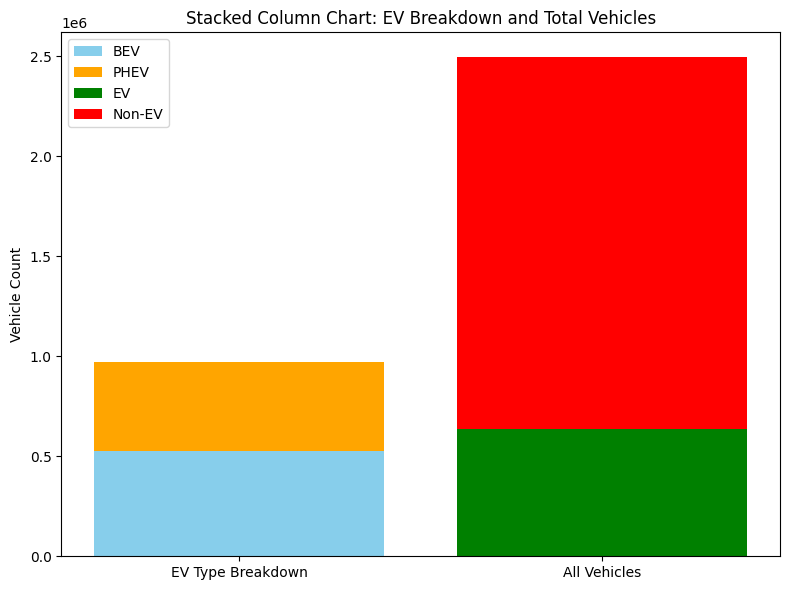

In [13]:
bev_total = df['Battery Electric Vehicles (BEVs)'].sum()
phev_total = df['Plug-In Hybrid Electric Vehicles (PHEVs)'].sum()
ev_total = df['Electric Vehicle (EV) Total'].sum()
non_ev_total = df['Non-Electric Vehicle Total'].sum()
all_total = df['Total Vehicles'].sum()

# Stacked column chart
fig, ax = plt.subplots(figsize=(8, 6))

# Stack EV types
ax.bar('EV Type Breakdown', bev_total, label='BEV', color='skyblue')
ax.bar('EV Type Breakdown', phev_total, bottom=bev_total, label='PHEV', color='orange')

# Stack Total Vehicle categories
ax.bar('All Vehicles', ev_total, label='EV', color='green')
ax.bar('All Vehicles', non_ev_total, bottom=ev_total, label='Non-EV', color='red')

# Final touches
ax.set_ylabel('Vehicle Count')
ax.set_title('Stacked Column Chart: EV Breakdown and Total Vehicles')
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['numeric_date'] = df['Date'].dt.year * 12 + df['Date'].dt.month

In [15]:
df = df.sort_values(['County', 'Date'])

In [16]:
df['months_since_start'] = df.groupby('County').cumcount()

#Lags are only based on past data from the same county
# === Create lag features (1–3 months) ===
for lag in [1, 2, 3]:
    df[f'ev_total_lag{lag}'] = df.groupby('County')['Electric Vehicle (EV) Total'].shift(lag)

# === Rolling average (3-month, prior) ===
df['ev_total_roll_mean_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                               .transform(lambda x: x.shift(1).rolling(3).mean())

# === Percent change (no fill method) ===
df['ev_total_pct_change_1'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=1, fill_method=None)

df['ev_total_pct_change_3'] = df.groupby('County')['Electric Vehicle (EV) Total'] \
                                .pct_change(periods=3, fill_method=None)

# === Clean up any infs/NaNs ===
df['ev_total_pct_change_1'] = df['ev_total_pct_change_1'].replace([np.inf, -np.inf], np.nan).fillna(0)
df['ev_total_pct_change_3'] = df['ev_total_pct_change_3'].replace([np.inf, -np.inf], np.nan).fillna(0)

In [17]:
df['cumulative_ev'] = df.groupby('County')['Electric Vehicle (EV) Total'].cumsum()

# 6-month rolling linear slope of cumulative growth
df['ev_growth_slope'] = df.groupby('County')['cumulative_ev'].transform(
    lambda x: x.rolling(6).apply(lambda y: np.polyfit(range(len(y)), y, 1)[0] if len(y) == 6 else np.nan)
)

In [18]:
df = df.dropna().reset_index(drop=True)

In [19]:
df.to_csv('preprocessed_ev_data.csv', index=False)

df.head()

,Date,County,State,Vehicle Primary Use,Battery Electric Vehicles (BEVs),Plug-In Hybrid Electric Vehicles (PHEVs),Electric Vehicle (EV) Total,Non-Electric Vehicle Total,Total Vehicles,Percent Electric Vehicles,...,numeric_date,months_since_start,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,cumulative_ev,ev_growth_slope
0,2018-05-31,Ada,ID,Passenger,0.0,2.0,2.0,341.0,343.0,0.58,...,24221,5,2.0,2.0,2.0,2.0,0.0,0.0,10.0,1.857143
1,2018-06-30,Ada,ID,Passenger,0.0,2.0,2.0,332.0,334.0,0.60,...,24222,6,2.0,2.0,2.0,2.0,0.0,0.0,12.0,2.000000
2,2018-07-31,Ada,ID,Passenger,0.0,2.0,2.0,329.0,331.0,0.60,...,24223,7,2.0,2.0,2.0,2.0,0.0,0.0,14.0,2.000000
3,2018-08-31,Ada,ID,Passenger,0.0,2.0,2.0,325.0,327.0,0.61,...,24224,8,2.0,2.0,2.0,2.0,0.0,0.0,16.0,2.000000
4,2018-09-30,Ada,ID,Passenger,0.0,2.0,2.0,327.0,329.0,0.61,...,24225,9,2.0,2.0,2.0,2.0,0.0,0.0,18.0,2.000000


In [23]:
features = [
    'months_since_start',
    'County',
    'ev_total_lag1',
    'ev_total_lag2',
    'ev_total_lag3',
    'ev_total_roll_mean_3',
    'ev_total_pct_change_1',
    'ev_total_pct_change_3',
    'ev_growth_slope',
]

target = 'Electric Vehicle (EV) Total'
X = df[features]
y = df[target]

X.head()

,months_since_start,County,ev_total_lag1,ev_total_lag2,ev_total_lag3,ev_total_roll_mean_3,ev_total_pct_change_1,ev_total_pct_change_3,ev_growth_slope
0,5,Ada,2.0,2.0,2.0,2.0,0.0,0.0,1.857143
1,6,Ada,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
2,7,Ada,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
3,8,Ada,2.0,2.0,2.0,2.0,0.0,0.0,2.000000
4,9,Ada,2.0,2.0,2.0,2.0,0.0,0.0,2.000000


In [22]:
print(df.columns.tolist())

['Date', 'County', 'State', 'Vehicle Primary Use', 'Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)', 'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total', 'Total Vehicles', 'Percent Electric Vehicles', 'year', 'month', 'numeric_date', 'months_since_start', 'ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3', 'ev_total_roll_mean_3', 'ev_total_pct_change_1', 'ev_total_pct_change_3', 'cumulative_ev', 'ev_growth_slope']


In [24]:
print(df.columns.tolist())

['Date', 'County', 'State', 'Vehicle Primary Use', 'Battery Electric Vehicles (BEVs)', 'Plug-In Hybrid Electric Vehicles (PHEVs)', 'Electric Vehicle (EV) Total', 'Non-Electric Vehicle Total', 'Total Vehicles', 'Percent Electric Vehicles', 'year', 'month', 'numeric_date', 'months_since_start', 'ev_total_lag1', 'ev_total_lag2', 'ev_total_lag3', 'ev_total_roll_mean_3', 'ev_total_pct_change_1', 'ev_total_pct_change_3', 'cumulative_ev', 'ev_growth_slope']


In [25]:

X.shape

(12573, 9)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

In [27]:
y_test.head()

11315    1.0
11316    1.0
11317    1.0
11318    1.0
11319    1.0
Name: Electric Vehicle (EV) Total, dtype: float64